Problem Statement
Recruiting and retaining drivers is seen by industry watchers as a tough battle for Ola. Churn among drivers is high and it’s very easy for drivers to stop working for the service on the fly or jump to Uber depending on the rates.
As the companies get bigger, the high churn could become a bigger problem. To find new drivers, Ola is casting a wide net, including people who don’t have cars for jobs. But this acquisition is really costly. Losing drivers frequently impacts the morale of the organization and acquiring new drivers is more expensive than retaining existing ones.
You are working as a data scientist with the Analytics Department of Ola, focused on driver team attrition. You are provided with the monthly information for a segment of drivers for 2019 and 2020 and tasked to predict whether a driver will be leaving the company or not based on their attributes like
Demographics (city, age, gender etc.)
Tenure information (joining date, Last Date)
Historical data regarding the performance of the driver (Quarterly rating, Monthly business acquired, grade, Income)


Column Profiling:
MMMM-YY : Reporting Date (Monthly)
Driver_ID : Unique id for drivers
Age : Age of the driver
Gender : Gender of the driver – Male : 0, Female: 1
City : City Code of the driver
Education_Level : Education level – 0 for 10+ ,1 for 12+ ,2 for graduate
Income : Monthly average Income of the driver
Date Of Joining : Joining date for the driver
LastWorkingDate : Last date of working for the driver
Joining Designation : Designation of the driver at the time of joining
Grade : Grade of the driver at the time of reporting
Total Business Value : The total business value acquired by the driver in a month (negative business indicates cancellation/refund or car EMI adjustments)
Quarterly Rating : Quarterly rating of the driver: 1,2,3,4,5 (higher is better)


In [965]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

import random
#For dealing with tables
import pandas as pd
#For dealing with linear algebra
import numpy as np
#For data visualization and plotting graphs
import matplotlib.pyplot as plt
import seaborn as sns
#For minmaxscaler
from sklearn.preprocessing import MinMaxScaler
#For shapiro test
from scipy.stats import shapiro
#For train-test split
from sklearn.model_selection import train_test_split,GridSearchCV
#For RandomForest
from sklearn.ensemble import RandomForestClassifier
#Accuracy score, confusion matrix, classification report, ROC curve, AUC
from sklearn.metrics import f1_score
#To ignore warnings
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix

from sklearn.impute import KNNImputer
from datetime import date


In [966]:
data=pd.read_csv('ola_driver_scaler.csv')
data.head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


In [967]:
#remove Unnamed column
data=data.drop(columns=['Unnamed: 0'])

In [968]:
#checking columns data type and null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MMM-YY                19104 non-null  object 
 1   Driver_ID             19104 non-null  int64  
 2   Age                   19043 non-null  float64
 3   Gender                19052 non-null  float64
 4   City                  19104 non-null  object 
 5   Education_Level       19104 non-null  int64  
 6   Income                19104 non-null  int64  
 7   Dateofjoining         19104 non-null  object 
 8   LastWorkingDate       1616 non-null   object 
 9   Joining Designation   19104 non-null  int64  
 10  Grade                 19104 non-null  int64  
 11  Total Business Value  19104 non-null  int64  
 12  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 1.9+ MB


In [969]:
# convert date columns from string to datetime

data['MMM-YY']=pd.to_datetime(data['MMM-YY'])
data['Dateofjoining']=pd.to_datetime(data['Dateofjoining'])
data['LastWorkingDate']=pd.to_datetime(data['LastWorkingDate'])


Imputation of missing data

In [970]:
#checking the percentage of null values
data.isnull().sum()/len(data)*100

MMM-YY                   0.000000
Driver_ID                0.000000
Age                      0.319305
Gender                   0.272194
City                     0.000000
Education_Level          0.000000
Income                   0.000000
Dateofjoining            0.000000
LastWorkingDate         91.541039
Joining Designation      0.000000
Grade                    0.000000
Total Business Value     0.000000
Quarterly Rating         0.000000
dtype: float64

In [971]:
#Return a subset of the DataFrame’s columns based on the column dtypes. Since KNN works only on numeric columns
data_num=data.select_dtypes(np.number)
data_num

,Driver_ID,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,1,28.0,0.0,2,57387,1,1,2381060,2
1,1,28.0,0.0,2,57387,1,1,-665480,2
2,1,28.0,0.0,2,57387,1,1,0,2
3,2,31.0,0.0,2,67016,2,2,0,1
4,2,31.0,0.0,2,67016,2,2,0,1
...,...,...,...,...,...,...,...,...,...
19099,2788,30.0,0.0,2,70254,2,2,740280,3
19100,2788,30.0,0.0,2,70254,2,2,448370,3
19101,2788,30.0,0.0,2,70254,2,2,0,2
19102,2788,30.0,0.0,2,70254,2,2,200420,2


KNN Imputation

In [972]:
imputer=KNNImputer(n_neighbors=5,weights='uniform', metric='nan_euclidean')
data_imputed=imputer.fit_transform(data_num)
data_imputed=pd.DataFrame(data=data_imputed,columns=data_num.columns)
data_imputed.isnull().sum()

Driver_ID               0
Age                     0
Gender                  0
Education_Level         0
Income                  0
Joining Designation     0
Grade                   0
Total Business Value    0
Quarterly Rating        0
dtype: int64

In [973]:
#Getting the remaining columns back
remaining_columns=data.columns.difference(data_imputed.columns)
data=pd.concat((data_imputed, data[remaining_columns]),axis=1)
data.head()

,Driver_ID,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,City,Dateofjoining,LastWorkingDate,MMM-YY
0,1.0,28.0,0.0,2.0,57387.0,1.0,1.0,2381060.0,2.0,C23,2018-12-24,NaT,2019-01-01
1,1.0,28.0,0.0,2.0,57387.0,1.0,1.0,-665480.0,2.0,C23,2018-12-24,NaT,2019-02-01
2,1.0,28.0,0.0,2.0,57387.0,1.0,1.0,0.0,2.0,C23,2018-12-24,2019-03-11,2019-03-01
3,2.0,31.0,0.0,2.0,67016.0,2.0,2.0,0.0,1.0,C7,2020-11-06,NaT,2020-11-01
4,2.0,31.0,0.0,2.0,67016.0,2.0,2.0,0.0,1.0,C7,2020-11-06,NaT,2020-12-01


Aggregating data at driver level

In [974]:
data_last_agg=data.groupby('Driver_ID').agg({'Age':'last','Gender':'last','Education_Level':'last',
                            'Income':'last','Joining Designation':'last','Grade':'last','Total Business Value':'sum','Quarterly Rating':'last','City':'last',
                            'Dateofjoining':'first','LastWorkingDate':'last'}).reset_index()

In [975]:
data_first_agg=data.groupby('Driver_ID').agg({'Education_Level':'first',
                            'Income':'first','Joining Designation':'first','Grade':'first','Total Business Value':'sum','Quarterly Rating':'first'}).reset_index()




In [976]:
#Feature Engineering

data_last_agg['Education_Level_Increase'] = data_last_agg['Education_Level']>data_first_agg['Education_Level']
data_last_agg['Quarterly_Rating_Increase'] = data_last_agg['Quarterly Rating']>data_first_agg['Quarterly Rating']
data_last_agg['Grade_Increase'] = data_last_agg['Grade']>data_first_agg['Grade']
data_last_agg['Income_Increase'] = data_last_agg['Income']>data_first_agg['Income']
data_last_agg['Last_Working_Date_not_null'] = data_last_agg['LastWorkingDate'].replace(np.nan, date.today())
data_last_agg['Last_Working_Date_not_null']=pd.to_datetime(data_last_agg['Last_Working_Date_not_null'])
data_last_agg['Tenure'] = data_last_agg['Last_Working_Date_not_null']-data_last_agg['Dateofjoining']
data_last_agg['Tenure'] = data_last_agg['Tenure'].dt.days
data_last_agg=pd.get_dummies(data=data_last_agg,columns=['City'],drop_first=True)

def tar(x):
    if x==np.nan:
        return 0
    else: 
        return 1


data_last_agg.replace([True,False], [1,0],inplace=True)
data_last_agg['Target'] = data_last_agg['LastWorkingDate'].isna()
data_last_agg.replace([True,False], [0,1],inplace=True)
data_last_agg.drop(columns=['Driver_ID','Dateofjoining','LastWorkingDate','Last_Working_Date_not_null'],inplace=True)
data_last_agg

,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,Education_Level_Increase,Quarterly_Rating_Increase,...,City_C28,City_C29,City_C3,City_C4,City_C5,City_C6,City_C7,City_C8,City_C9,Target
0,28.0,0.0,2.0,57387.0,1.0,1.0,1715580.0,2.0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,31.0,0.0,2.0,67016.0,2.0,2.0,0.0,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,43.0,0.0,2.0,65603.0,2.0,2.0,350000.0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,29.0,0.0,0.0,46368.0,1.0,1.0,120360.0,1.0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,31.0,1.0,1.0,78728.0,3.0,3.0,1265000.0,2.0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,34.0,0.0,0.0,82815.0,2.0,3.0,21748820.0,4.0,0,1,...,0,0,0,0,0,0,0,0,0,0
2377,34.0,1.0,0.0,12105.0,1.0,1.0,0.0,1.0,0,0,...,0,0,0,0,0,0,0,0,1,1
2378,45.0,0.0,0.0,35370.0,2.0,2.0,2815090.0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,1
2379,28.0,1.0,2.0,69498.0,1.0,1.0,977830.0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [977]:
data_last_agg['Target'].value_counts(normalize=True)

1    0.678706
0    0.321294
Name: Target, dtype: float64

1616 drivers have left the company which amounts to ~68% of the total employees

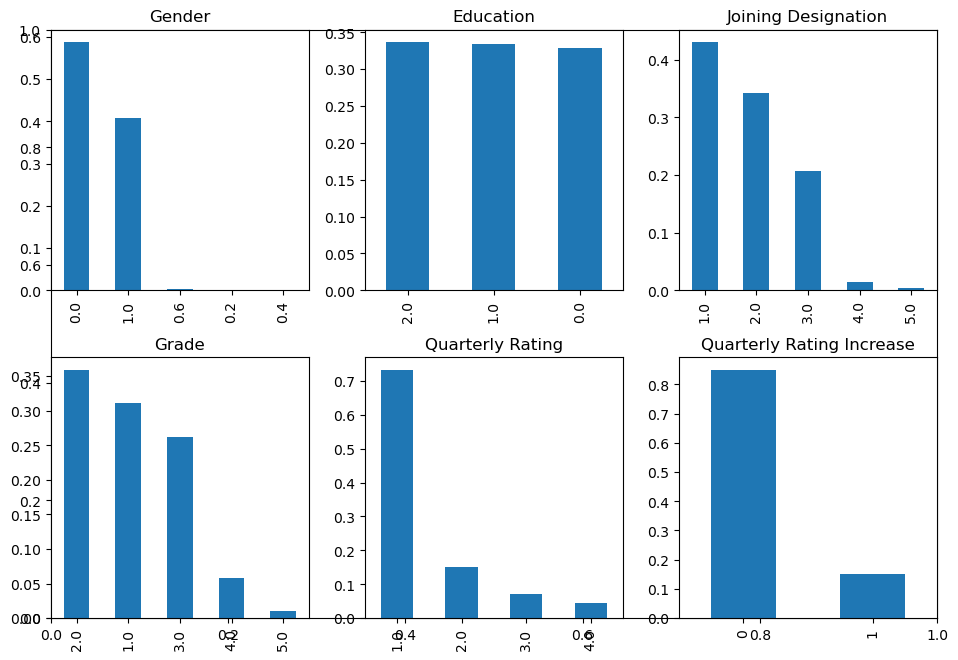

In [978]:
#Distirbution of the total employees by various categorical features

cols=['Gender','Education_Level','Joining Designation','Grade','Quarterly Rating','Quarterly_Rating_Increase']

plt.subplots(figsize=(10,7))
plt.subplot(231)
data_last_agg['Gender'].value_counts(normalize=True).plot.bar(title='Gender')

plt.subplot(232)
data_last_agg['Education_Level'].value_counts(normalize=True).plot.bar(title='Education')

plt.subplot(233)
data_last_agg['Joining Designation'].value_counts(normalize=True).plot.bar(title='Joining Designation')

plt.subplot(234)
data_last_agg['Grade'].value_counts(normalize=True).plot.bar(title='Grade')

plt.subplot(235)
data_last_agg['Quarterly Rating'].value_counts(normalize=True).plot.bar(title='Quarterly Rating')

plt.subplot(236)
data_last_agg['Quarterly_Rating_Increase'].value_counts(normalize=True).plot.bar(title='Quarterly Rating Increase')
plt.tight_layout()


Around 59% of the employees are Male.

There seems to be an equal distrbution of employees across various education levels i.e. 34%.

43% of the employees joined at Grade 1.

At present, ~35% of the employees have their designation at grade 2.

~72% of the employees had their last quarterly rating as 1.

Quarterly rating has not increased for around 83% of the employees. 


Text(0.5, 1.0, 'Income')

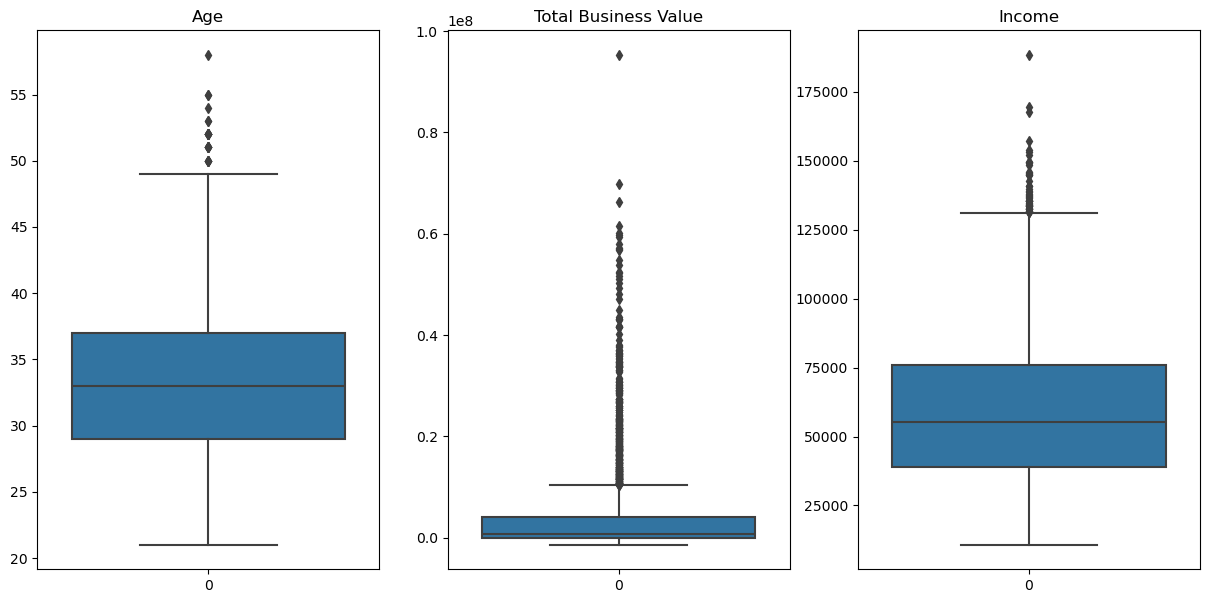

In [979]:
#Checking outliers

figure,axes=plt.subplots(1,3,figsize=(15,7))

sns.boxplot(data_last_agg['Age'],ax=axes[0]).set_title('Age')
sns.boxplot(data_last_agg['Total Business Value'],ax=axes[1]).set_title('Total Business Value')
sns.boxplot(data_last_agg['Income'],ax=axes[2]).set_title('Income')


Separating features and target as X and Y

In [980]:


X=data_last_agg.drop(columns=['Target'])
Y=data_last_agg['Target']
X


,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,Education_Level_Increase,Quarterly_Rating_Increase,...,City_C27,City_C28,City_C29,City_C3,City_C4,City_C5,City_C6,City_C7,City_C8,City_C9
0,28.0,0.0,2.0,57387.0,1.0,1.0,1715580.0,2.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,31.0,0.0,2.0,67016.0,2.0,2.0,0.0,1.0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,43.0,0.0,2.0,65603.0,2.0,2.0,350000.0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,29.0,0.0,0.0,46368.0,1.0,1.0,120360.0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,31.0,1.0,1.0,78728.0,3.0,3.0,1265000.0,2.0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,34.0,0.0,0.0,82815.0,2.0,3.0,21748820.0,4.0,0,1,...,0,0,0,0,0,0,0,0,0,0
2377,34.0,1.0,0.0,12105.0,1.0,1.0,0.0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,1
2378,45.0,0.0,0.0,35370.0,2.0,2.0,2815090.0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2379,28.0,1.0,2.0,69498.0,1.0,1.0,977830.0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0


Scaling and splitting the data

In [981]:
#scaling

scaler=MinMaxScaler()
X_scaled=scaler.fit_transform(X)

#splitting into train and test

X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size = 0.20, random_state = 7)

In [982]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1904, 41), (477, 41), (1904,), (477,))

Random Forest with Class Weights

In [983]:
param= {'max_depth':[2,3,4], 'n_estimators':[50,100,150,200]}

random_forest= RandomForestClassifier(class_weight='balanced')
c= GridSearchCV(random_forest,param_grid=param,cv=5,scoring='f1')
c.fit(X_train,y_train)



GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'max_depth': [2, 3, 4],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='f1')

In [984]:
print(c.best_params_)
print(c.best_score_)

{'max_depth': 4, 'n_estimators': 100}
0.9744866195120698


Classification Report

In [985]:


y_pred=c.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       148
           1       1.00      0.96      0.98       329

    accuracy                           0.97       477
   macro avg       0.95      0.98      0.96       477
weighted avg       0.97      0.97      0.97       477



In [986]:
random_forest_=RandomForestClassifier(class_weight='balanced',max_depth=4,n_estimators=150)
random_forest_.fit(X_train,y_train)
y_predict=random_forest_.predict(X_test)

print(classification_report(y_test,y_predict))




              precision    recall  f1-score   support

           0       0.91      0.99      0.95       148
           1       1.00      0.96      0.98       329

    accuracy                           0.97       477
   macro avg       0.95      0.98      0.96       477
weighted avg       0.97      0.97      0.97       477



Top 5 features impacting the target value

In [987]:


feature_importances=list(random_forest_.feature_importances_)

n=0
feature_importances_index=[]
for feature in feature_importances:
    feature_importances_index.append((feature,n))
    n=n+1

def fun(x):
    return x[0]

feature_importances_index=sorted(feature_importances_index,key=fun,reverse=True)

# top 5 important features
for _ in range(5):
    print(X.columns[feature_importances_index[_][1]])

Tenure
Quarterly Rating
Total Business Value
Quarterly_Rating_Increase
Income


Heatmap to analyse the correlation of the top 5 features with the target

<Axes: >

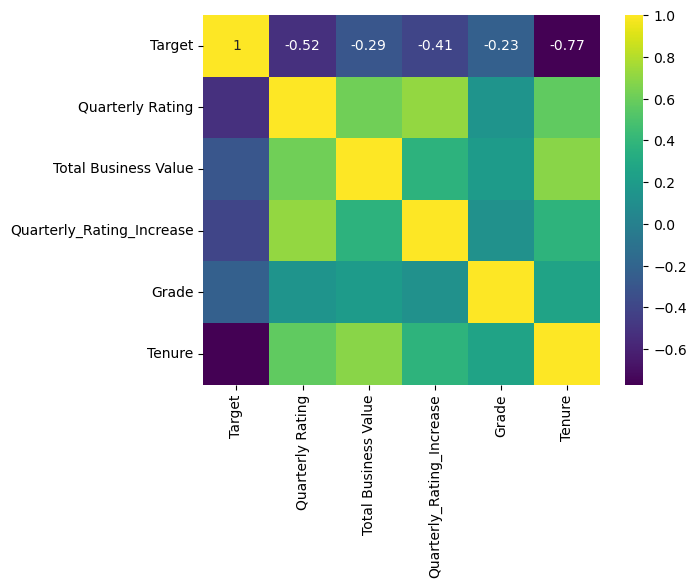

In [988]:
data_heatmap=pd.DataFrame(data=data_last_agg[['Target','Quarterly Rating','Total Business Value','Quarterly_Rating_Increase','Grade','Tenure',]])

sns.heatmap(data_heatmap.corr(method='spearman'), annot=True, cmap='viridis')

Analysing the effect of top 5 features in detail 

<Axes: title={'center': 'Last Grade with The Target'}, xlabel='Grade'>

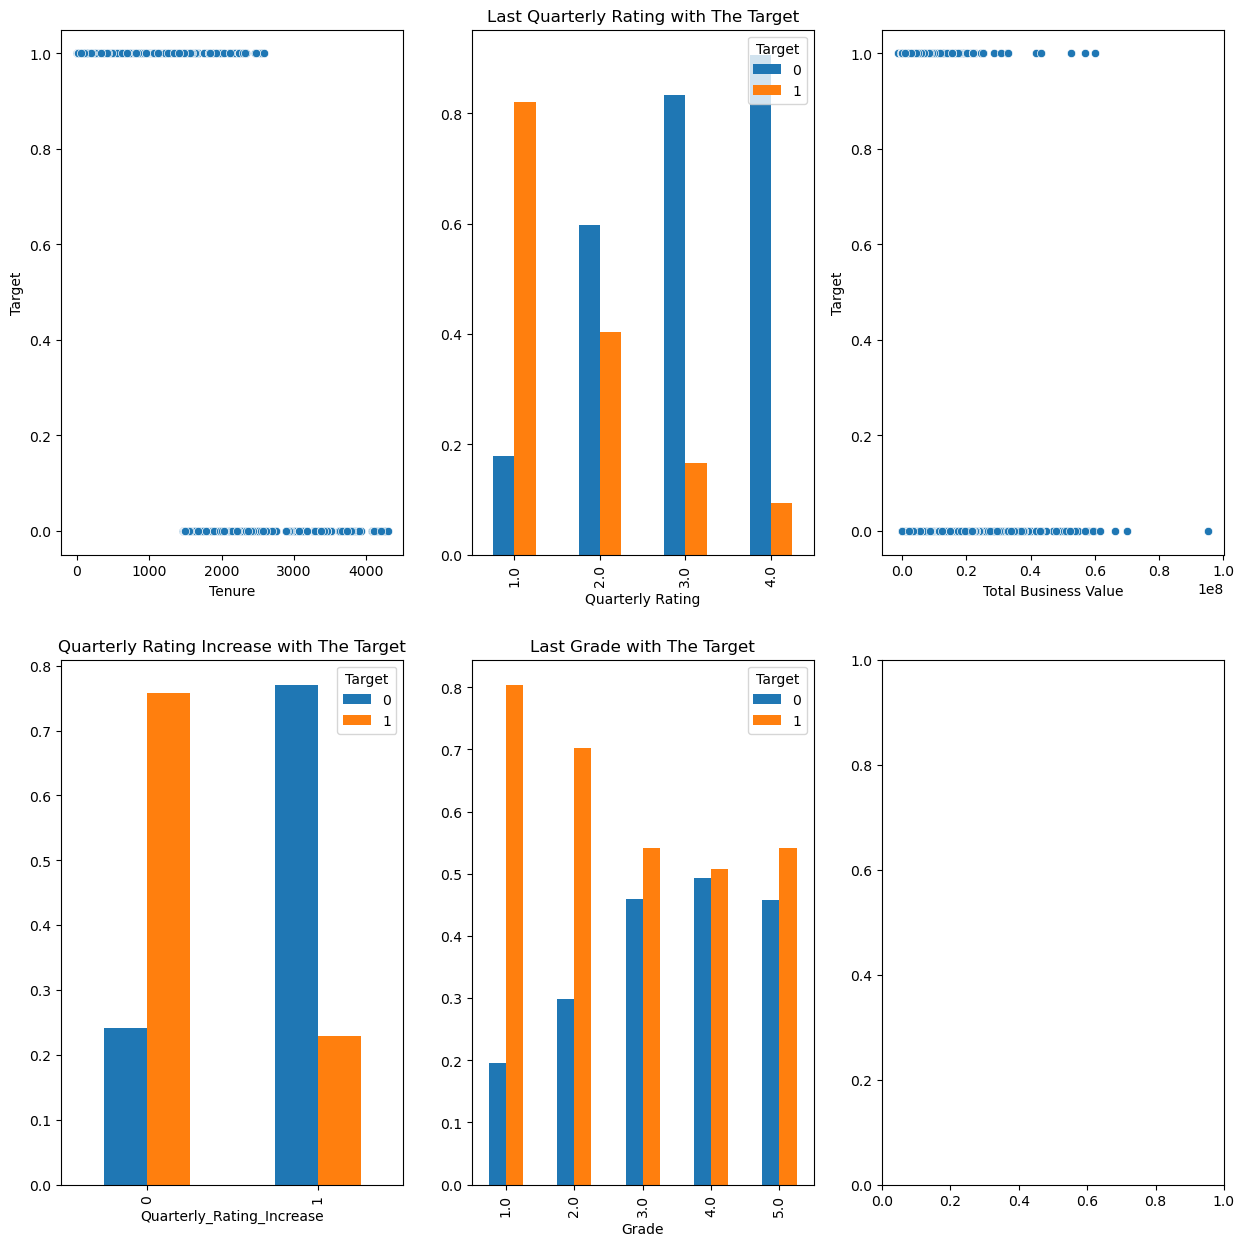

In [989]:
figure,axes=plt.subplots(2,3,figsize=(15,15))

sns.scatterplot(x=data_last_agg['Tenure'],y=data_last_agg['Target'],ax=axes[0,0])

Quarterly_Rating = pd.crosstab(data_last_agg['Quarterly Rating'],data_last_agg['Target'])
Quarterly_Rating.div(Quarterly_Rating.sum(1).astype(float),axis=0).plot(kind='bar',stacked=False,ax=axes[0,1],title="Last Quarterly Rating with The Target")

Total_Business_Value = sns.scatterplot(x=data_last_agg['Total Business Value'],y=data_last_agg['Target'],ax=axes[0,2])

Quarterly_Rating_Increase = pd.crosstab(data_last_agg['Quarterly_Rating_Increase'],data_last_agg['Target'])
Quarterly_Rating_Increase.div(Quarterly_Rating_Increase.sum(1).astype(float),axis=0).plot(kind='bar',stacked=False,ax=axes[1,0],title="Quarterly Rating Increase with The Target")

Grade = pd.crosstab(data_last_agg['Grade'],data_last_agg['Target'])
Grade.div(Grade.sum(1).astype(float),axis=0).plot(kind='bar',stacked=False,ax=axes[1,1],title="Last Grade with The Target")

Tenure is highly inversely correlated with the target i.e. employees are more likely to leave more when their tenure is less. 

Employees having the last quarterly rating as 1 are more likely to leave the org. 

Employees are more likely to leave more when their quartely rating hasn't increased.

Employees at Grade 1 and 2 are more likely to leave.


Checking the results with boosting

In [991]:
import xgboost as xgb
xg = xgb.XGBClassifier(class_weight ='balanced')
xg.fit(X_train, y_train)

# Predicting the Test set results
y_pred = xg.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print(cm)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       148
           1       1.00      0.99      0.99       329

    accuracy                           0.99       477
   macro avg       0.99      0.99      0.99       477
weighted avg       0.99      0.99      0.99       477

[[148   0]
 [  4 325]]


Hence, we got similar results with boosting as well.